# Training ANN potentials

This notebook demonstrates the training of neural-network based ML potentials.  Note that the data set used here is very small and meant for demonstration only; the resulting MLIP cannot be expected to be good.

**Note: Training requires the ænet binaries to be correctly installed and configured.**

## 1. Featurization of the data set

Featurization with the AUC method is already demonstrated in a separate notebook.  Here, we follow the same approach for a small data set of TiO$_2$ structures that are in ænet's extended XSF format (with energy and force labels).

In [1]:
import glob
from aenet.featurize import AenetAUCFeaturizer

# the AUC featurizer uses the Chebyshev method (Artrith 2017)
fzer = AenetAUCFeaturizer(['Ti', 'O'],
                          rad_cutoff=6.0, rad_order=10, 
                          ang_cutoff=4.0, ang_order=3)

# aenet's generate.x will be run in the specified subdirectory ('run').
# If no work directory is given, a temporary directory is created and
# removed after completion.
fzer.run_aenet_generate(glob.glob("./xsf-TiO2/*.xsf"), 
                        atomic_energies={
                            'O': -432.503149303,
                            'Ti': -1604.604515075},
                        workdir='run')

## 2. Training

Once the featurization has completed, the training can be run in the same work directory.  The available options and training methods are detailed in the documentation.

**Note: The L-BFGS-B method is currently not suppported on macOS, since it relies on legacy Fortran code that is not compatible with the Apple Accelerate framework for BLAS/LAPACK.**

**Note also: MPI parallelization is currently also only supported on Linux.**

In [2]:
from aenet.mlip import ANNPotential, TrainingConfig, Adam

# The ANN architecture only needs to define the hidden layers, 
# as in the usual `train.in` input format.
arch = {
    'Ti': [(10, 'tanh'), (10, 'tanh')],
    'O': [(10, 'tanh'), (10, 'tanh')]
}

mlp = ANNPotential(arch)

# Training run over 100 epochs with the Adam method
config = TrainingConfig(
    iterations=10,
    method=Adam(mu=0.001, batchsize=8, samplesize=100),
    sampling='random',
    max_energy=1.0,
    save_energies=True,
    testpercent=10
)

# Note that we use the same `workdir` as for the featurization.  
# When using a different directory, the path to the training set
# file needs to be specified.
results = mlp.train(config=config, workdir='run')

# On Linux, MPI parallelization is supported as long as the 
# `train.x` executable was compiled with MPI support.
# mlp.train(config=config, workdir='run', num_processes=32)

Training: 100%|███████████████████████████████| 100/100 [00:10<00:00,  9.98it/s]


## 3. Inspection of the results

Once the training has completed, the results can be inspected with the `TrainOutput` class.

In [3]:
print(results)

Training statistics:
  final_MAE_train: 0.6640209
  final_RMSE_train: 0.7525026
  final_MAE_test: 0.7365712
  final_RMSE_test: 0.7785468
  min_RMSE_test: 0.7785468
  epoch_min_RMSE_test: 11



Generate a plot of the train/validation set RMSE:

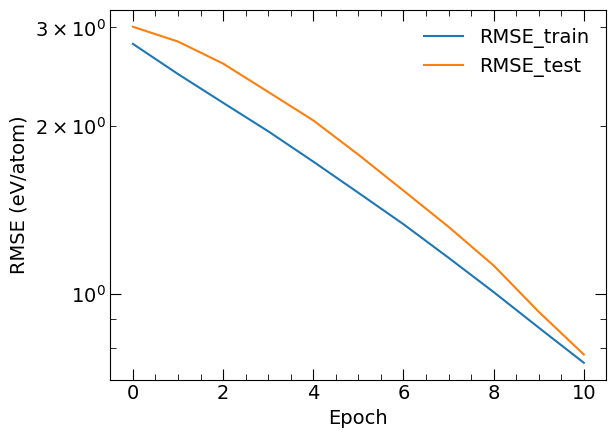

In [4]:
results.plot_training_errors()

If the structure energies have been saved (activated with `save_energies=True` in the above training config), a parity plot can be generated with:

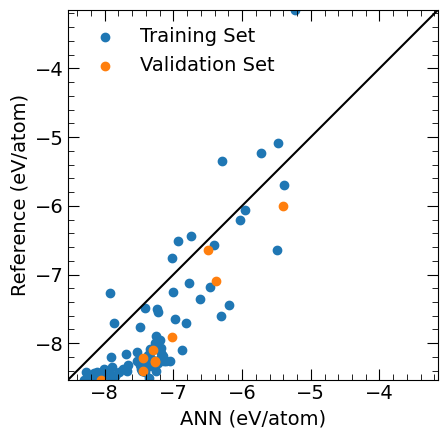

In [5]:
results.energies.plot_correlation()

The train and test errors are also directly available for inspection in a pandas DataFrame, along with other information.

In [6]:
results.energies.energies_test

,Ref(eV),ANN(eV),#atoms,Ref(eV/atom),ANN(eV/atom),Ref-ANN(eV/atom),Cost-Func,#Ti,#O,Path-of-input-file
0,-197.31520,-178.77730,24,-8.221465,-7.449056,-0.772409,-0.286713,8,16,../xsf-TiO2/structure-062.xsf
1,-49.62831,-43.61869,6,-8.271385,-7.269781,-1.001603,-0.371788,2,4,../xsf-TiO2/structure-063.xsf
2,-181.71450,-159.96690,22,-8.259750,-7.271225,-0.988525,-0.366933,8,14,../xsf-TiO2/structure-071.xsf
3,-47.49631,-42.15423,6,-7.916051,-7.025705,-0.890346,-0.330490,2,4,../xsf-TiO2/structure-065.xsf
4,-170.19610,-152.98240,24,-7.091505,-6.374267,-0.717238,-0.266233,8,16,../xsf-TiO2/structure-098.xsf
5,-144.15630,-129.58580,24,-6.006513,-5.399409,-0.607104,-0.225352,8,16,../xsf-TiO2/structure-072.xsf
6,-193.29850,-171.31860,23,-8.404281,-7.448636,-0.955645,-0.354728,8,15,../xsf-TiO2/structure-004.xsf
7,-39.88812,-38.97446,6,-6.648021,-6.495743,-0.152278,-0.056524,2,4,../xsf-TiO2/structure-009.xsf
8,-178.19460,-160.55230,22,-8.099756,-7.297834,-0.801922,-0.297668,8,14,../xsf-TiO2/structure-031.xsf
9,-51.22766,-48.35581,6,-8.537943,-8.059301,-0.478641,-0.177668,2,4,../xsf-TiO2/structure-057.xsf
